# Question 1 — Quantum Fourier Transform (QFT) assignment

Controlled phase rotations are defined as

$R_k = \mathrm{diag}\bigl(1, e^{i\pi/2^{k-1}}\bigr) \quad\text{for } k\ge 2.$

Unless stated otherwise, take $n=3$ (so $N=2^n=8$).

---

Input vector and padding. Use the complex vector

$v = (1,\; i,\; 2.5,\; 4 + i,\; 5,\; 7) \in \mathbb{C}^6.$

Pad to length $N=8$ with zeros:

$v' = (1,\; i,\; 2.5,\; 4 + i,\; 5,\; 7,\; 0,\; 0).$

When comparing with the classical FFT, use the unitary normalization $1/\sqrt{N}$ so magnitudes and phases align with the QFT unitary. If you test any alternate padding/normalization, state it clearly.

---

Erroneous QFT. Define $\widehat{\mathrm{QFT}}_N$ as the usual QFT circuit except that every gate that *should* be $R_3$ (i.e. phase $e^{i\pi/4}$) is replaced by $R_2$ (phase $e^{i\pi/2}$). All other gates (Hadamards, $R_2$, $R_4$, …, final swaps) remain correct.


Q1.1 Implement the erroneous QFT $\widehat{\mathrm{QFT}}_N$ where every intended $R_3$ is replaced by $R_2$. Provide a minimal diagram or a gate list that documents exactly which locations are affected.

Q1.2 Prepare the (padded) input state $|v'\rangle$ by amplitude encoding (normalize appropriately). Using the Hadamard test with a single ancilla, estimate the complex output amplitudes

$$a_j^{(\mathrm{err})} = \langle j | \widehat{\mathrm{QFT}}_N | v' \rangle \qquad (j = 0, \dots, 7).$$

Report the estimated $\mathrm{Re}\,a_j^{(\mathrm{err})}$ and $\mathrm{Im}\,a_j^{(\mathrm{err})}$ with error bars from the Hadamard-test sampling.

Q1.3 Baselines and comparisons:

- Compute the classical DFT of $v'$ using NumPy/FFT with $1/\sqrt{N}$ normalization.
- Compute the correct QFT output amplitudes

$$a_j^{(\mathrm{true})} = \langle j | \mathrm{QFT}_N | v' \rangle.
$$

Produce a figure showing magnitudes and phases vs. $j$ for the three results: Hadamard-test (erroneous), correct QFT, and classical FFT.

Q1.4 Now imagine the carelessly-prepared QFT circuit is correct but the experimenter has introduced a noisy $R_3$ modeled by the unitary

$$U_{\mathrm{noise}} = \begin{pmatrix} 1-\varepsilon & \delta \\ \delta & 1-\varepsilon \end{pmatrix},$$

and the implemented controlled rotation is $U_{\mathrm{noise}} \cdot R_3$ (control uses this noisy gate in place of the ideal $R_3$). Choose $\delta$ so that the matrix is unitary; let $\varepsilon$ be a random real number between $0$ and $0.1$. Apply this perturbation independently in front of each $R_3$ location, rerun the experiments, and report findings comparing with the correct classical FFT.

---



## naming conventions (updated, lowercase)

Core variables now use lowercase to avoid confusion:
- num_qubits (was NUM_QUBITS, nq)
- dim (was DIM, N in some demo cells)
- vec_raw : original (unpadded) complex input
- vec_padded : zero-padded to length dim
- state_vec : normalized padded vector used for amplitude encoding
- prep_circuit : prepares |state_vec>
- qft_err : erroneous qft (R3 replaced by R2)
- qft_true : correct qft

Hadamard test helper:
- hadamard_test_all_j(shots, qft_circuit, prep_circuit, state_vec, ...)

Backward-compatibility aliases (deprecated) are set but you should NOT rely on them:
- NUM_QUBITS, DIM, DEFAULT_SHOTS map to their lowercase counterparts.

Indexing:
- Natural order by default; pass bit_reversed_index=True only to reproduce older results that accidentally reversed bits.

All subsequent edits conform to this naming.

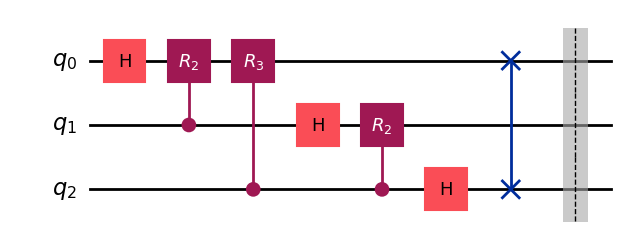

In [52]:

from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
import numpy as np
num_qubits = 3

# Function to create a custom rotation gate R_k
def Rotation_gate(k):

    # Define the matrix for the custom gate
    phase = np.exp(1j * np.pi / (2 ** (k - 1)))
    matrix = np.diag([1, phase])
    
    # Create the custom gate with the label R_k
    custom_gate = UnitaryGate(matrix, label=f'$R_{k}$')
    return custom_gate.control()

R = Rotation_gate

# Create a quantum circuit with 3 qubits
qc = QuantumCircuit(3)

# Step 1: Apply respective gates to the 1st qubit
qc.h(0)                     # Hadamard gate on qubit 0
qc.append(R(2), [1, 0])     # R_2 C-P gate with pi/2 on qubits 0 and 1
qc.append(R(3), [2, 0])     # R_3 C-P gate with pi/2 on qubits 0 and 2

# Step 2: Apply respective gates to the 2nd and 3rd qubits
qc.h(1)                     # Hadamard gate on qubit 1
qc.append(R(2), [2, 1])     # R_2 C-P gate with pi/2 on qubits 1 and 2

qc.h(2)                     # Hadamard gate on qubit 2

# Step 3: Swap the qubits to reverse their order
qc.swap(0, 2)
qc.barrier()                # Add a barrier for clarity

# Draw the circuit to visualize it
qc.draw('mpl') 

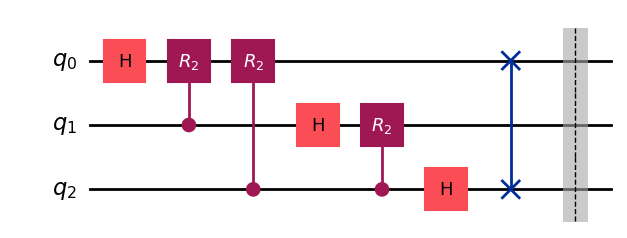

In [53]:
# Question 1.1 
# Just for diagram purpose - Using phase gate is more efficient as the transpiler 
# will decompose it more optimally as phase gates are native to Qiskit.

from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
import numpy as np
num_qubits = 3

# Function to create a custom rotation gate R_k
def Rotation_gate(k):

    # Define the matrix for the custom gate
    phase = np.exp(1j * np.pi / (2 ** (k - 1)))
    matrix = np.diag([1, phase])
    
    # Create the custom gate with the label R_k
    custom_gate = UnitaryGate(matrix, label=f'$R_{k}$')
    return custom_gate.control()

R = Rotation_gate

# Create a quantum circuit with 3 qubits
qc = QuantumCircuit(3)

# Step 1: Apply respective gates to the 1st qubit
qc.h(0)                     # Hadamard gate on qubit 0
qc.append(R(2), [1, 0])     # R_2 C-P gate with pi/2 on qubits 0 and 1
qc.append(R(2), [2, 0])     # R_2 C-P gate with pi/2 on qubits 0 and 2 
                            # (as R_3 is replaced by R_2 as given in the question)

# Step 2: Apply respective gates to the 2nd and 3rd qubits
qc.h(1)                     # Hadamard gate on qubit 1
qc.append(R(2), [2, 1])     # R_2 C-P gate with pi/2 on qubits 1 and 2

qc.h(2)                     # Hadamard gate on qubit 2

# Step 3: Swap the qubits to reverse their order
qc.swap(0, 2)
qc.barrier()                # Add a barrier for clarity

# Draw the circuit to visualize it
qc.draw('mpl')              # Quantum Fourier Transform Circuit for 3 Qubits with replaced R_3 by R_2


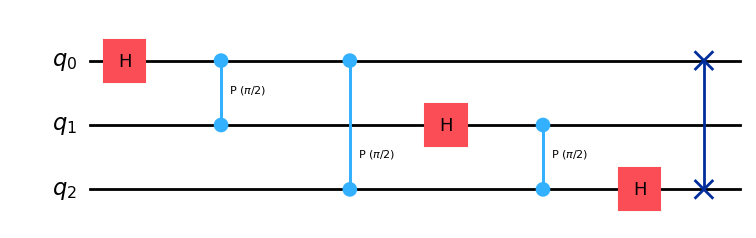

In [54]:
# ---------------------------------------------------------------------------
# Erroneous QFT construction (qft_err)
# ---------------------------------------------------------------------------
# This circuit implements a 3‑qubit QFT except that every controlled R3
# (phase π/4) gate is intentionally replaced by an R2 (phase π/2) gate.
# A final swap layer (0 <-> 2) is included to put the output in natural index
# order (so amplitudes directly correspond to computational basis integers).
# ---------------------------------------------------------------------------

from qiskit import QuantumCircuit
from qiskit.circuit.library import PhaseGate
import numpy as np

# Base phase gate R2 (π/2). We reuse its controlled form for all locations.
R2  = PhaseGate(np.pi/2, label='R2')
R2c = R2.control()

qft_err = QuantumCircuit(num_qubits, name='qft_err')

# Qubit 0 (MSB): Hadamard then two (intentionally R2) controlled rotations
qft_err.h(0)
qft_err.append(R2c, [1, 0])          # should be R2 (correct)
qft_err.append(R2c, [2, 0])          # should be R3, replaced by R2 (error)

# Qubit 1: Hadamard then controlled R2 from qubit 2
qft_err.h(1)
qft_err.append(R2c, [2, 1])          # correct R2

# Qubit 2: final Hadamard
qft_err.h(2)

# Output reordering (bit reversal) to match standard QFT convention
qft_err.swap(0, 2)

display(qft_err.draw('mpl'))

In [55]:
#Q1.2 Real and imaginary part error vs j

import qiskit
print(qiskit.__version__)
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit_aer import Aer
from qiskit.circuit.library import PhaseGate, StatePreparation
from qiskit.quantum_info import Operator
from qiskit.compiler import transpile

# core dimensions (lowercase)
dim = 2 ** num_qubits

# raw input vector (unpadded)
vec_raw = np.array([1, 1j, 2.5, 4 + 1j, 5, 7], dtype=complex)

# default shots for sampling
default_shots = 12000


2.2.1


normalized state_vec: [0.100377+0.j       0.      +0.100377j 0.250943+0.j
 0.401508+0.100377j 0.501886+0.j       0.70264 +0.j
 0.      +0.j       0.      +0.j      ]


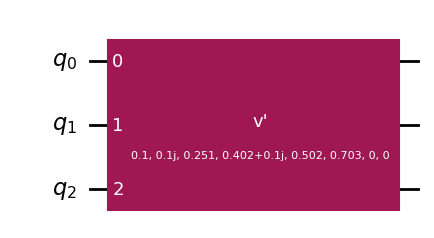

In [56]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
import numpy as np

# ---------------------------------------------------------------------------
# State Preparation Utilities
# ---------------------------------------------------------------------------
# We build a circuit that amplitude‑encodes the (possibly shorter) complex
# input vector into 'num_qubits' qubits. The vector is first zero‑padded to
# dimension 'dim' and then normalized.  The resulting normalized vector
# (state_vec) is what the quantum circuit prepares from |0...0>.
# ---------------------------------------------------------------------------

def build_state_preparation(vec_raw, dim_len, num_qb=num_qubits):
    """Create a state‑preparation circuit.

    Steps
    -----
    1. Zero‑pad the raw vector to length 'dim_len'.
    2. Normalize the padded vector -> state_vec.
    3. Construct a QuantumCircuit that prepares |state_vec>.

    Parameters
    ----------
    vec_raw : np.ndarray
        Original complex vector (may be shorter than 2**num_qubits).
    dim_len : int
        Target dimension (= 2**num_qubits).
    num_qb : int
        Number of qubits.

    Returns
    -------
    prep : QuantumCircuit
        Circuit that prepares |state_vec>.
    state_vec : np.ndarray
        Normalized padded vector (length dim_len).
    vec_padded : np.ndarray
        The padded (unnormalized) vector (for reference / inspection).
    """
    # Zero‑pad to full dimension
    vec_padded = np.pad(vec_raw, (0, dim_len - len(vec_raw)), mode='constant')
    
    # Normalize (protect against zero vector, though not expected here)
    norm = np.linalg.norm(vec_padded)
    if norm == 0:
        raise ValueError("Input vector is zero; cannot normalize for amplitude encoding.")
    state_vec = vec_padded / norm
    
    # Build the preparation circuit
    prep = QuantumCircuit(num_qb, name='prep')
    prep_gate = StatePreparation(state_vec, label="v'")  # amplitude encoding gate
    prep.append(prep_gate, list(range(num_qb)))
    
    return prep, state_vec, vec_padded

# Build once (can be reused by all experiments)
prep_circuit, state_vec, vec_padded = build_state_preparation(vec_raw, dim)

print("normalized state_vec:", np.round(state_vec, 6))
prep_circuit.draw('mpl')

In [57]:
# ---------------------------------------------------------------------------
# Exact amplitudes helper
# ---------------------------------------------------------------------------
# Given a QFT(-like) circuit and the prepared state_vec, compute the exact
# output amplitudes by matrix multiplication:  U |state_vec>.
# ---------------------------------------------------------------------------

def compute_exact_amplitudes(qft_circuit, state_vec):
    U = Operator(qft_circuit).data            # full 8x8 unitary (for 3 qubits)
    amps = U @ state_vec                      # resulting output amplitudes
    print("\nexact amplitudes (complex only):")
    for j, a in enumerate(amps):
        print(f" j={j}: {a:.6f}")
    return amps

amps_err_exact = compute_exact_amplitudes(qft_err, state_vec)


exact amplitudes (complex only):
 j=0: 0.692029+0.070977j
 j=1: -0.159699+0.070977j
 j=2: -0.195188+0.425864j
 j=3: -0.195188-0.425864j
 j=4: 0.070977-0.159699j
 j=5: 0.070977-0.017744j
 j=6: 0.070977+0.017744j
 j=7: -0.070977+0.017744j


### construction of $U'$ (lowercase names)
- `state_vec`: normalized padded input
- `prep_circuit`: prepares |state_vec>
- `qft_err`: erroneous qft
For each j build V_j (|0>→|j>):
$$ U'_j = V_j^\dagger\; qft\_err\; prep\_circuit $$
so $\langle 0|U'_j|0\rangle = \langle j|qft\_err|state\_vec\rangle$.

In [58]:
# Backward compatibility wrapper (thin)
# Hadamard test (full sweep over all j)
# ---------------------------------------------------------------------------
# For each computational basis index j, we build a unitary U'_j such that
# <0| U'_j |0> = <j| qft_circuit | state_vec>.  We then perform the standard
# Hadamard test (real and imaginary parts separately) using one ancilla.
# ---------------------------------------------------------------------------

def hadamard_test_all_j(shots, qft_circuit, prep_circuit, state_vec,
                         show_reference=False, label=None, bit_reversed_index=False):
    """Estimate Re/Im of all output amplitudes of qft_circuit |state_vec>.

    Parameters
    ----------
    shots : int
        Number of samples per (real / imag) Hadamard test circuit.
    qft_circuit : QuantumCircuit
        The (possibly erroneous) QFT-like unitary under study.
    prep_circuit : QuantumCircuit
        Circuit preparing |state_vec>.
    state_vec : np.ndarray
        Normalized input state vector (length dim).
    show_reference : bool
        If True, print matrix-derived exact amplitudes (no stats).
    label : str | None
        Optional label included in printed header.
    bit_reversed_index : bool
        If True, apply legacy bit reversal when constructing V_j (avoid unless reproducing older runs).
    """
    backend = Aer.get_backend('qasm_simulator')
    label = label or qft_circuit.name

    # ---------------------------
    # Build V_j (maps |0> -> |j>)
    # ---------------------------
    def make_vj(j):
        V = QuantumCircuit(num_qubits, name=f'V{j}')
        bits = format(j, f'0{num_qubits}b')
        if bit_reversed_index:
            bits = bits[::-1]            # legacy / diagnostic option
        for q, b in enumerate(bits):
            if b == '1':
                V.x(q)
        return V

    # -------------------------------------------
    # Construct U'_j = V_j^† · qft_circuit · prep
    # -------------------------------------------
    def build_uprime(j):
        inst_prep = prep_circuit.to_instruction()
        inst_qft  = qft_circuit.to_instruction()
        vj_dag = make_vj(j).to_instruction().inverse()
        Uprime = QuantumCircuit(num_qubits, name=f"U'_j{j}")
        Uprime.append(inst_prep, range(num_qubits))
        Uprime.append(inst_qft,  range(num_qubits))
        Uprime.append(vj_dag,    range(num_qubits))
        return Uprime.to_instruction()

    # Reference amplitudes (optional)
    ref = Operator(qft_circuit).data @ state_vec if show_reference else None

    # -------------------------------------------
    # Single j Hadamard test (returns dict)
    # -------------------------------------------
    def run_j(j):
        Uprime = build_uprime(j)
        gate = Gate(name=Uprime.name, num_qubits=Uprime.num_qubits, params=[])
        gate.definition = Uprime.definition
        ctrl = gate.control()
        anc = 0
        sys = list(range(1, num_qubits+1))

        # Real part circuit
        qc_r = QuantumCircuit(1+num_qubits, 1)
        qc_r.h(anc)
        qc_r.append(ctrl, [anc] + sys)
        qc_r.h(anc)
        qc_r.measure(anc, 0)

        # Imag part circuit
        qc_i = QuantumCircuit(1+num_qubits, 1)
        qc_i.h(anc)
        qc_i.sdg(anc)
        qc_i.append(ctrl, [anc] + sys)
        qc_i.h(anc)
        qc_i.measure(anc, 0)

        # Execute real
        tr = transpile(qc_r, backend)
        rr = backend.run(tr, shots=shots).result()
        p0 = rr.get_counts().get('0', 0) / shots
        re = 2 * p0 - 1
        se_re = 2 * np.sqrt(max(p0 * (1 - p0), 0) / shots)

        # Execute imag
        ti = transpile(qc_i, backend)
        ri = backend.run(ti, shots=shots).result()
        p0i = ri.get_counts().get('0', 0) / shots
        im = 2 * p0i - 1
        se_im = 2 * np.sqrt(max(p0i * (1 - p0i), 0) / shots)

        return {
            'j': j,
            'Re': re,
            'Im': im,
            'SE_Re': se_re,
            'SE_Im': se_im,
            'Ref': (ref[j] if ref is not None else None)
        }

    # Run over all j
    results = [run_j(j) for j in range(dim)]

    # Pretty print
    print(f"[{label}] hadamard test (shots={shots})")
    for r in results:
        print(f" j={r['j']}: Re={r['Re']:.6f} ± {r['SE_Re']:.6f}, Im={r['Im']:.6f} ± {r['SE_Im']:.6f}")

    if show_reference:
        print("\nreference amplitudes (matrix, natural order):")
        for r in results:
            a = r['Ref']
            print(f" j={r['j']}: {a.real:+.6f}{a.imag:+.6f}j")

    return results

# Backward compatibility wrapper (thin)
def run_experiment(shots, QFT=qft_err, show_reference=False, label=None, qc_prep=None, v=None):
    prep = qc_prep if qc_prep is not None else prep_circuit
    sv = v if v is not None else state_vec
    return hadamard_test_all_j(shots, QFT, prep, sv, show_reference=show_reference, label=label)

# Example usage (erroneous circuit)
_ = hadamard_test_all_j(10000, qft_circuit=qft_err, prep_circuit=prep_circuit, state_vec=state_vec, label='erroneous')

[erroneous] hadamard test (shots=10000)
 j=0: Re=0.695200 ± 0.007188, Im=0.064000 ± 0.009979
 j=1: Re=0.094000 ± 0.009956, Im=-0.152000 ± 0.009884
 j=2: Re=-0.195800 ± 0.009806, Im=0.435800 ± 0.009000
 j=3: Re=0.064600 ± 0.009979, Im=0.028800 ± 0.009996
 j=4: Re=-0.170400 ± 0.009854, Im=0.079400 ± 0.009968
 j=5: Re=0.085600 ± 0.009963, Im=-0.002800 ± 0.010000
 j=6: Re=-0.182400 ± 0.009832, Im=-0.431400 ± 0.009022
 j=7: Re=-0.066800 ± 0.009978, Im=0.021000 ± 0.009998


[qft_err] hadamard test (shots=10000)
 j=0: Re=0.694000 ± 0.007200, Im=0.073200 ± 0.009973
 j=1: Re=0.090000 ± 0.009959, Im=-0.185800 ± 0.009826
 j=2: Re=-0.207000 ± 0.009783, Im=0.415600 ± 0.009095
 j=3: Re=0.051600 ± 0.009987, Im=0.006400 ± 0.010000
 j=4: Re=-0.149600 ± 0.009887, Im=0.071200 ± 0.009975
 j=5: Re=0.081000 ± 0.009967, Im=-0.028600 ± 0.009996
 j=6: Re=-0.206400 ± 0.009785, Im=-0.422000 ± 0.009066
 j=7: Re=-0.077200 ± 0.009970, Im=0.022200 ± 0.009998
[qft_err] hadamard test (shots=1000000)
 j=0: Re=0.692934 ± 0.000721, Im=0.069580 ± 0.000998
 j=1: Re=0.071854 ± 0.000997, Im=-0.156868 ± 0.000988
 j=2: Re=-0.195878 ± 0.000981, Im=0.425952 ± 0.000905
 j=3: Re=0.072308 ± 0.000997, Im=0.018622 ± 0.001000
 j=4: Re=-0.159392 ± 0.000987, Im=0.071448 ± 0.000997
 j=5: Re=0.070680 ± 0.000997, Im=-0.016938 ± 0.001000
 j=6: Re=-0.193506 ± 0.000981, Im=-0.426102 ± 0.000905
 j=7: Re=-0.071778 ± 0.000997, Im=0.018446 ± 0.001000


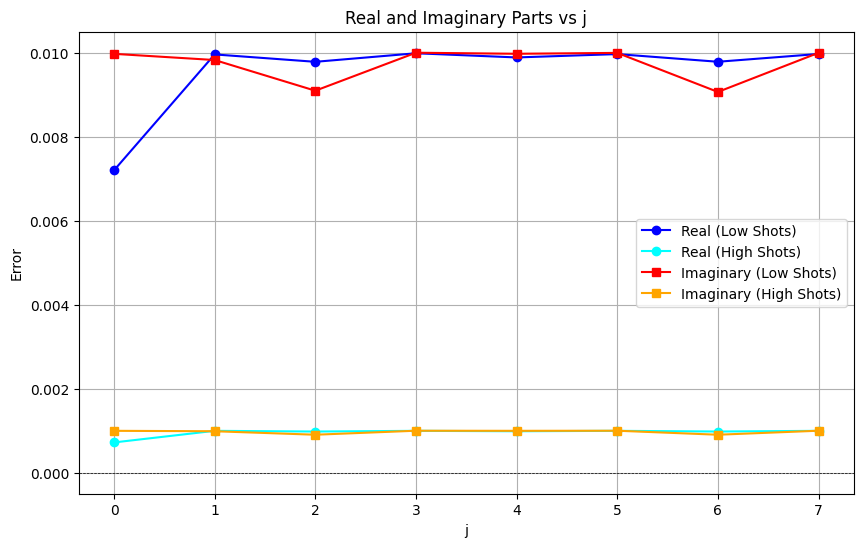

In [59]:
Low_shots = run_experiment(10000)
High_shots = run_experiment(1000000)
import matplotlib.pyplot as plt

# Extract real and imaginary parts for Low_shots and High_shots
j_values = [res['j'] for res in Low_shots]
re_low = [res['SE_Re'] for res in Low_shots]
im_low = [res['SE_Im'] for res in Low_shots]
re_high = [res['SE_Re'] for res in High_shots]
im_high = [res['SE_Im'] for res in High_shots]

# Plot real and imaginary parts
plt.figure(figsize=(10, 6))

# Real part
plt.plot(j_values, re_low, 'o-', label='Real (Low Shots)', color='blue')
plt.plot(j_values, re_high, 'o-', label='Real (High Shots)', color='cyan')

# Imaginary part
plt.plot(j_values, im_low, 's-', label='Imaginary (Low Shots)', color='red')
plt.plot(j_values, im_high, 's-', label='Imaginary (High Shots)', color='orange')

# Labels and legend
plt.xlabel('j')
plt.ylabel('Error')
plt.title('Real and Imaginary Parts vs j')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

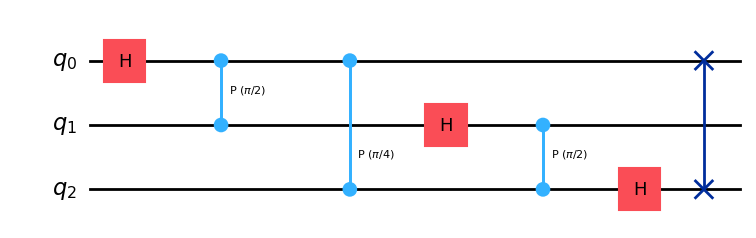

In [60]:
#Q1.3 QFT vs QFT_err vs classical FFT

# ---------------------------------------------------------------------------
# Correct QFT circuit (qft_true)
# ---------------------------------------------------------------------------
# Standard 3‑qubit QFT with controlled phases R2 (π/2) and R3 (π/4) and final
# swap layer so output indexing matches natural binary order.
# ---------------------------------------------------------------------------

from qiskit import QuantumCircuit
from qiskit.circuit.library import PhaseGate

R2  = PhaseGate(np.pi/2, label='R2')
R3  = PhaseGate(np.pi/4, label='R3')
R2c = R2.control()
R3c = R3.control()

qft_true = QuantumCircuit(num_qubits, name='qft_true')

# Qubit 0 layer
qft_true.h(0)
qft_true.append(R2c, [1,0])
qft_true.append(R3c, [2,0])

# Qubit 1 layer
qft_true.h(1)
qft_true.append(R2c, [2,1])

# Qubit 2 layer
qft_true.h(2)

# Reorder qubits (bit reversal)
qft_true.swap(0,2)

display(qft_true.draw('mpl'))

## Q1.3 Baselines and Comparisons

We now compare three outputs for the padded, normalized input state $|v'\rangle$ (dimension $N=8$):
1. Erroneous QFT (Hadamard test estimates) where every intended $R_3$ was replaced by $R_2$.
2. Correct QFT exact amplitudes (ideal 3‑qubit QFT with swaps so indices are in natural order).
3. Classical DFT with unitary normalization $1/\sqrt{N}$ (positive exponent convention matching the QFT used).

We plot magnitude $|a_j|$ and phase $\arg(a_j)$ for each $j=0,\dots,7$ after aligning global phase to the exact correct QFT result. Hadamard test points include 1 s.e. error bars derived from binomial statistics for Re/Im and linearly propagated to magnitude and phase.


[erroneous_Q1.3] hadamard test (shots=1000000)
 j=0: Re=0.691964 ± 0.000722, Im=0.071360 ± 0.000997
 j=1: Re=0.069914 ± 0.000998, Im=-0.160750 ± 0.000987
 j=2: Re=-0.196908 ± 0.000980, Im=0.427010 ± 0.000904
 j=3: Re=0.070378 ± 0.000998, Im=0.016088 ± 0.001000
 j=4: Re=-0.160216 ± 0.000987, Im=0.071396 ± 0.000997
 j=5: Re=0.071572 ± 0.000997, Im=-0.017712 ± 0.001000
 j=6: Re=-0.193968 ± 0.000981, Im=-0.426796 ± 0.000904
 j=7: Re=-0.070974 ± 0.000997, Im=0.017612 ± 0.001000


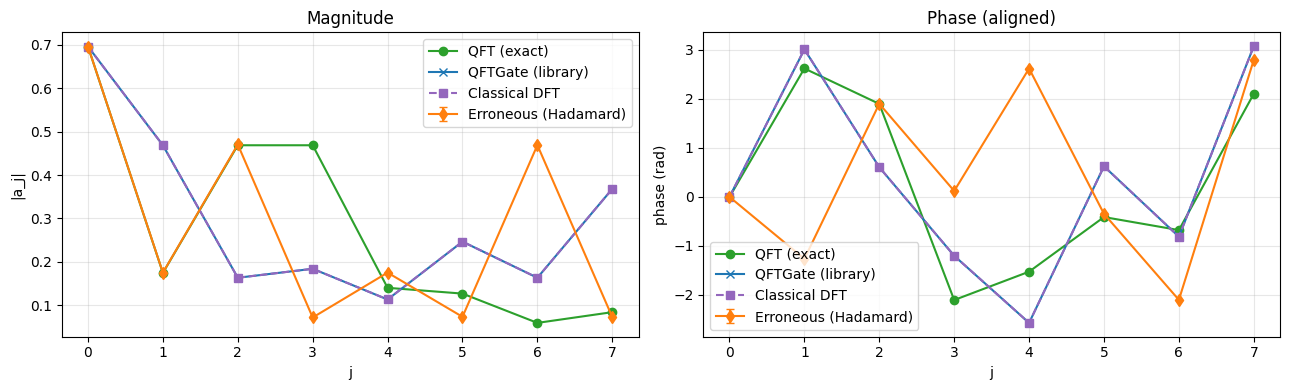

Max |Δ magnitude| (err vs true): 0.409043110673752
Max |Δ phase| (err vs true): 4.144626862626324
Max |Δ| library vs true (magnitude): 0.3048692186930116
Max |Δ| library vs true (phase): 1.291932333763915


In [61]:
# Q1.3 comparison figure (erroneous Hadamard vs correct QFT vs classical DFT vs inbuilt QFTGate)
# This cell is now self-contained: it rebuilds any missing prerequisites so it can run
# even if executed out of order.
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.circuit.library import PhaseGate, StatePreparation, QFTGate

# -----------------------------
# Reconstruct prerequisites if absent
# -----------------------------
if 'num_qubits' not in globals():
    num_qubits = 3
if 'vec_raw' not in globals():
    vec_raw = np.array([1, 1j, 2.5, 4+1j, 5, 7], dtype=complex)
if 'dim' not in globals():
    dim = 2 ** num_qubits
if 'state_vec' not in globals() or 'prep_circuit' not in globals():
    vec_padded = np.pad(vec_raw, (0, dim - len(vec_raw)), mode='constant')
    state_vec = vec_padded / np.linalg.norm(vec_padded)
    prep_circuit = QuantumCircuit(num_qubits, name='prep')
    prep_circuit.append(StatePreparation(state_vec, label="v'"), range(num_qubits))

# Erroneous QFT (rebuild if missing)
if 'qft_err' not in globals():
    R2  = PhaseGate(np.pi/2, label='R2')
    R2c = R2.control()
    qft_err = QuantumCircuit(num_qubits, name='qft_err')
    qft_err.h(0)
    qft_err.append(R2c, [1,0])            # correct R2
    qft_err.append(R2c, [2,0])            # should be R3 -> replaced (error)
    qft_err.h(1)
    qft_err.append(R2c, [2,1])
    qft_err.h(2)
    qft_err.swap(0,2)

# Correct QFT (rebuild minimal if missing)
if 'qft_true' not in globals():
    qft_true = QuantumCircuit(num_qubits, name='qft_true')
    R2  = PhaseGate(np.pi/2, label='R2')
    R3  = PhaseGate(np.pi/4, label='R3')
    qft_true.h(0); qft_true.append(R2.control(), [1,0]); qft_true.append(R3.control(), [2,0])
    qft_true.h(1); qft_true.append(R2.control(), [2,1])
    qft_true.h(2)
    qft_true.swap(0,2)

# Hadamard test helper (rebuild if needed)
if 'hadamard_test_all_j' not in globals():
    from qiskit_aer import Aer
    from qiskit.circuit import Gate
    from qiskit.compiler import transpile
    def hadamard_test_all_j(shots, qft_circuit, prep_circuit, state_vec, show_reference=False, label=None, bit_reversed_index=False):
        backend = Aer.get_backend('qasm_simulator')
        dim_local = 2 ** qft_circuit.num_qubits
        n = qft_circuit.num_qubits
        def make_vj(j):
            qc_v = QuantumCircuit(n, name=f'V{j}')
            bits = format(j, f'0{n}b')
            if bit_reversed_index:
                bits = bits[::-1]
            for q, b in enumerate(bits):
                if b == '1':
                    qc_v.x(q)
            return qc_v
        inst_prep = prep_circuit.to_instruction()
        inst_qft  = qft_circuit.to_instruction()
        def build_uprime(j):
            vj_dag = make_vj(j).to_instruction().inverse()
            circ = QuantumCircuit(n, name=f"U'_j{j}")
            circ.append(inst_prep, range(n))
            circ.append(inst_qft,  range(n))
            circ.append(vj_dag,    range(n))
            return circ.to_instruction()
        ref = Operator(qft_circuit).data @ state_vec if show_reference else None
        def run_j(j):
            Uprime = build_uprime(j)
            gate = Gate(name=Uprime.name, num_qubits=Uprime.num_qubits, params=[])
            gate.definition = Uprime.definition
            ctrl = gate.control()
            anc = 0; sys = list(range(1, n+1))
            # Real
            qc_r = QuantumCircuit(1+n, 1)
            qc_r.h(anc); qc_r.append(ctrl, [anc]+sys); qc_r.h(anc); qc_r.measure(anc,0)
            tr = transpile(qc_r, backend); rr = backend.run(tr, shots=shots).result()
            p0 = rr.get_counts().get('0', 0)/shots; re = 2*p0 - 1
            se_re = 2*np.sqrt(max(p0*(1-p0),0)/shots)
            # Imag
            qc_i = QuantumCircuit(1+n,1)
            qc_i.h(anc); qc_i.sdg(anc); qc_i.append(ctrl, [anc]+sys); qc_i.h(anc); qc_i.measure(anc,0)
            ti = transpile(qc_i, backend); ri = backend.run(ti, shots=shots).result()
            p0i = ri.get_counts().get('0',0)/shots; im = 2*p0i - 1
            se_im = 2*np.sqrt(max(p0i*(1-p0i),0)/shots)
            return {'j': j, 'Re': re, 'Im': im, 'SE_Re': se_re, 'SE_Im': se_im, 'Ref': (ref[j] if ref is not None else None)}
        results = [run_j(j) for j in range(dim_local)]
        return results

# -----------------------------
# Helper functions (local)
# -----------------------------

def _classical_qft(v):
    N = len(v)
    k = np.arange(N)
    x = k.reshape(-1, 1)
    F = np.exp(2j * np.pi * x * k / N) / np.sqrt(N)
    return F @ v

def _align_global_phase(a, ref):
    for r in ref:
        if abs(r) > 1e-12:
            return a * np.conj(r) / abs(r), ref * np.conj(r) / abs(r)
    return a, ref

# -----------------------------
# Compute required amplitude sets
# -----------------------------
try:
    a_true_exact = Operator(qft_true).data @ state_vec
except Exception as e:
    raise RuntimeError(f"Failed to compute exact QFT amplitudes: {e}")

a_classical = _classical_qft(state_vec)

# Inbuilt / library QFTGate amplitudes
qft_library_gate = QFTGate(num_qubits=num_qubits)
a_inbuilt = Operator(qft_library_gate).data @ state_vec

# Hadamard test for erroneous circuit
HAD_SHOTS = 1000000  # adjust for precision/runtime tradeoff
had_err = hadamard_test_all_j(HAD_SHOTS, qft_err, prep_circuit, state_vec, label='erroneous_Q1.3')
a_err_est = np.array([r['Re'] + 1j*r['Im'] for r in had_err])
se_re = np.array([r['SE_Re'] for r in had_err])
se_im = np.array([r['SE_Im'] for r in had_err])

# Phase alignment against correct QFT
a_class_aligned, a_true_aligned = _align_global_phase(a_classical, a_true_exact)
a_err_aligned, _       = _align_global_phase(a_err_est, a_true_exact)
a_inbuilt_aligned, _   = _align_global_phase(a_inbuilt, a_true_exact)

# Magnitudes & phases
mag_true    = np.abs(a_true_aligned);    phase_true    = np.angle(a_true_aligned)
mag_class   = np.abs(a_class_aligned);   phase_class   = np.angle(a_class_aligned)
mag_err     = np.abs(a_err_aligned);     phase_err     = np.angle(a_err_aligned)
mag_inbuilt = np.abs(a_inbuilt_aligned); phase_inbuilt = np.angle(a_inbuilt_aligned)

# Propagate SE for erroneous to magnitude & phase
x = a_err_est.real; y = a_err_est.imag
mag_raw = np.abs(a_err_est)
mag_se = np.zeros_like(mag_raw)
phase_se = np.zeros_like(mag_raw)
nonzero = mag_raw > 1e-12
mag_se[nonzero] = (x[nonzero]*se_re[nonzero] + y[nonzero]*se_im[nonzero]) / mag_raw[nonzero]
den_phase = x**2 + y**2
phase_se[nonzero] = np.abs(x[nonzero]*se_im[nonzero] - y[nonzero]*se_re[nonzero]) / den_phase[nonzero]

j = np.arange(len(a_true_exact))

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(1,2, figsize=(13,4))
# Magnitude plot
ax[0].plot(j, mag_true, 'o-', label='QFT (exact)', color='tab:green')
ax[0].plot(j, mag_inbuilt, 'x-', label='QFTGate (library)', color='tab:blue')
ax[0].plot(j, mag_class, 's--', label='Classical DFT', color='tab:purple')
ax[0].errorbar(j, mag_err, yerr=np.abs(mag_se), fmt='d-', label='Erroneous (Hadamard)', color='tab:orange', capsize=3)
ax[0].set_xlabel('j'); ax[0].set_ylabel('|a_j|'); ax[0].set_title('Magnitude')
ax[0].grid(alpha=0.3); ax[0].legend()
# Phase plot
ax[1].plot(j, phase_true, 'o-', label='QFT (exact)', color='tab:green')
ax[1].plot(j, phase_inbuilt, 'x-', label='QFTGate (library)', color='tab:blue')
ax[1].plot(j, phase_class, 's--', label='Classical DFT', color='tab:purple')
ax[1].errorbar(j, phase_err, yerr=phase_se, fmt='d-', label='Erroneous (Hadamard)', color='tab:orange', capsize=3)
ax[1].set_xlabel('j'); ax[1].set_ylabel('phase (rad)'); ax[1].set_title('Phase (aligned)')
ax[1].grid(alpha=0.3); ax[1].legend()
plt.tight_layout(); plt.show()

print("Max |Δ magnitude| (err vs true):", float(np.max(np.abs(mag_err - mag_true))))
print("Max |Δ phase| (err vs true):", float(np.max(np.abs(phase_err - phase_true))))
print("Max |Δ| library vs true (magnitude):", float(np.max(np.abs(mag_inbuilt - mag_true))))
print("Max |Δ| library vs true (phase):", float(np.max(np.abs(phase_inbuilt - phase_true))))


## Q1.4 Noisy $R_3$ Gates (Random Unitary Injection)
We now treat the QFT as otherwise correct but each ideal $R_3$ is *preceded* by a noise unitary

$[ U_{\text{noise}} = \begin{pmatrix} 1-\epsilon & i\sqrt{\epsilon(2-\epsilon)} \\ i\sqrt{\epsilon(2-\epsilon)} & 1-\epsilon \end{pmatrix}, \qquad \epsilon \sim \mathcal{U}[0,0.1]. $
This choice ($\delta = i\sqrt{\epsilon(2-\epsilon)}$) guarantees unitarity since columns remain orthonormal: $(1-\epsilon)^2 + |\delta|^2 = 1$.
For $n=3$ there is only one $R_3$ gate, but code generalizes if more appear. For each trial we draw a fresh $\epsilon$ and build a new noisy QFT. We compare the resulting output amplitudes against the *ideal* QFT (and classical DFT, which matches ideal up to global phase) collecting statistics over many trials.
We report per-index mean/standard deviation of magnitude and phase deviations and summarize global maxima.


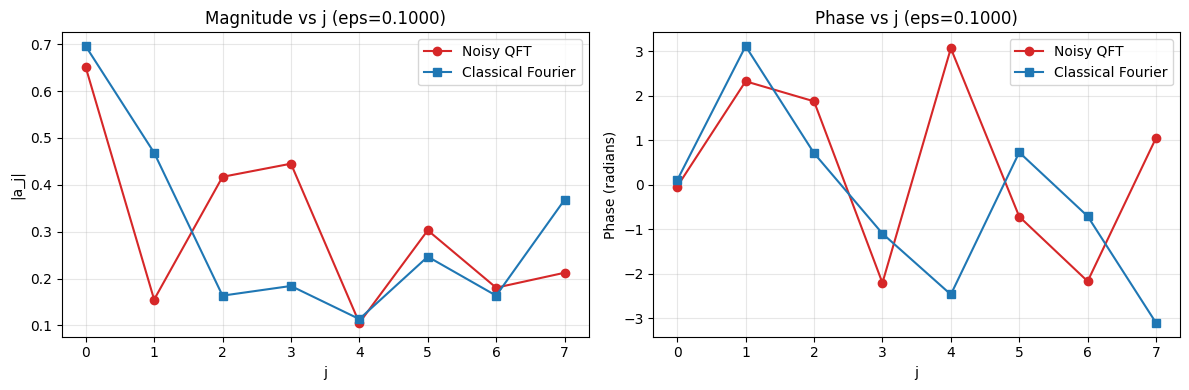

In [70]:
# Q1.4 Noisy QFT vs classical FFT
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit.library import PhaseGate
from qiskit.quantum_info import Operator

# --- Parameters and input ---
num_qubits = 3
dim = 2 ** num_qubits
vec_raw = np.array([1, 1j, 2.5, 4 + 1j, 5, 7], dtype=complex)
vec_padded = np.pad(vec_raw, (0, dim - len(vec_raw)), mode='constant')
state_vec = vec_padded / np.linalg.norm(vec_padded)

# --- Classical DFT (unitary normalization) ---
def classical_qft(v):
    N = len(v)
    k = np.arange(N)
    x = k.reshape(-1, 1)
    F = np.exp(2j * np.pi * x * k / N) / np.sqrt(N)
    return F @ v

a_classical_ref = classical_qft(state_vec)

# --- Correct QFT circuit ---
R2 = PhaseGate(np.pi/2, label='R2')
R3 = PhaseGate(np.pi/4, label='R3')
R2c = R2.control()
R3c = R3.control()
qft_true = QuantumCircuit(num_qubits, name='qft_true')
qft_true.h(0)
qft_true.append(R2c, [1,0])
qft_true.append(R3c, [2,0])
qft_true.h(1)
qft_true.append(R2c, [2,1])
qft_true.h(2)
qft_true.swap(0,2)
a_true_ref = Operator(qft_true).data @ state_vec

# --- Helper: align global phase ---
def align_global_phase(a, ref):
    for r in ref:
        if abs(r) > 1e-12:
            return a * np.conj(r) / abs(r), ref * np.conj(r) / abs(r)
    return a, ref

# --- Noisy R3 builder ---
def build_noisy_qft(num_qubits=3, pre_noise=True):
    # Only R3 gates are noisy; R2 gates are ideal
    R2 = PhaseGate(np.pi/2, label='R2')
    R3 = PhaseGate(np.pi/4, label='R3')
    R2c = R2.control()
    # Generate random epsilon and delta for each R3
    eps = 0.1
    delta = 1j * np.sqrt(eps * (2 - eps))
    Unoise = np.array([[1-eps, delta], [delta, 1-eps]])
    Unoise_gate = PhaseGate(0)  # placeholder for UnitaryGate
    from qiskit.circuit.library import UnitaryGate
    Unoise_gate = UnitaryGate(Unoise, label='Unoise')
    Unoise_c = Unoise_gate.control()
    # Build circuit
    qc = QuantumCircuit(num_qubits, name='noisy_qft')
    qc.h(0)
    qc.append(R2c, [1,0])
    if pre_noise:
        qc.append(Unoise_c, [2,0])
        qc.append(R3.control(), [2,0])
    else:
        qc.append(R3.control(), [2,0])
        qc.append(Unoise_c, [2,0])
    qc.h(1)
    qc.append(R2c, [2,1])
    qc.h(2)
    qc.swap(0,2)
    return qc, eps

# --- Run noisy QFT experiment ---
noisy_qc, eps = build_noisy_qft(num_qubits=num_qubits, pre_noise=True)
a_noisy = Operator(noisy_qc).data @ state_vec

# --- Align phase to ideal ---
a_noisy_al, a_true_al = align_global_phase(a_noisy, a_true_ref)

# --- Compute magnitude and phase for noisy QFT and classical Fourier transform ---
mag_noisy = np.abs(a_noisy_al)
phase_noisy = np.angle(a_noisy_al)
mag_classical = np.abs(a_classical_ref)
phase_classical = np.angle(a_classical_ref)
j = np.arange(dim)

# --- Plot magnitude vs j and phase vs j ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(j, mag_noisy, 'o-', label='Noisy QFT', color='tab:red')
ax[0].plot(j, mag_classical, 's-', label='Classical Fourier', color='tab:blue')
ax[0].set_title(f'Magnitude vs j (eps={eps:.4f})')
ax[0].set_xlabel('j')
ax[0].set_ylabel('|a_j|')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(j, phase_noisy, 'o-', label='Noisy QFT', color='tab:red')
ax[1].plot(j, phase_classical, 's-', label='Classical Fourier', color='tab:blue')
ax[1].set_title(f'Phase vs j (eps={eps:.4f})')
ax[1].set_xlabel('j')
ax[1].set_ylabel('Phase (radians)')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [63]:
# Q1.4 Visualization: Animated GIF of magnitude/phase vs j as eps transitions from 0 to 0.1
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit.library import PhaseGate, UnitaryGate
from qiskit.quantum_info import Operator
import imageio
import os

num_qubits = 3
vec_raw = np.array([1, 1j, 2.5, 4 + 1j, 5, 7], dtype=complex)
dim = 2 ** num_qubits
vec_padded = np.pad(vec_raw, (0, dim - len(vec_raw)), mode='constant')
state_vec = vec_padded / np.linalg.norm(vec_padded)

# Reference: correct QFT
R2 = PhaseGate(np.pi/2, label='R2')
R3 = PhaseGate(np.pi/4, label='R3')
R2c = R2.control()
R3c = R3.control()
qft_true = QuantumCircuit(num_qubits, name='qft_true')
qft_true.h(0)
qft_true.append(R2c, [1,0])
qft_true.append(R3c, [2,0])
qft_true.h(1)
qft_true.append(R2c, [2,1])
qft_true.h(2)
qft_true.swap(0,2)
a_true_ref = Operator(qft_true).data @ state_vec
j = np.arange(dim)

# Helper: align global phase
def align_global_phase(a, ref):
    for r in ref:
        if abs(r) > 1e-12:
            return a * np.conj(r) / abs(r), ref * np.conj(r) / abs(r)
    return a, ref

# Animated frames
frames = []
epsilons = np.linspace(0, 0.1, 30)  # Added definition for epsilons
for eps in epsilons:
    delta = 1j * np.sqrt(eps * (2 - eps))
    Unoise = np.array([[1-eps, delta], [delta, 1-eps]])
    Unoise_gate = UnitaryGate(Unoise, label='Unoise')
    Unoise_c = Unoise_gate.control()
    qc = QuantumCircuit(num_qubits, name='noisy_qft')
    qc.h(0)
    qc.append(R2c, [1,0])
    qc.append(Unoise_c, [2,0])
    qc.append(R3.control(), [2,0])
    qc.h(1)
    qc.append(R2c, [2,1])
    qc.h(2)
    qc.swap(0,2)
    a_noisy = Operator(qc).data @ state_vec
    a_noisy_al, a_true_al = align_global_phase(a_noisy, a_true_ref)
    mag_noisy = np.abs(a_noisy_al)
    phase_noisy = np.angle(a_noisy_al)
    # Plot
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(j, np.abs(a_true_al), 'o-', label='Ideal QFT', color='tab:green', alpha=0.5)
    ax[0].plot(j, mag_noisy, 's-', label='Noisy QFT', color='tab:red')
    ax[0].set_title(f'Magnitude |a_j|, eps={eps:.3f}')
    ax[0].set_xlabel('j'); ax[0].set_ylabel('|a_j|')
    ax[0].legend(); ax[0].grid(alpha=0.3)
    ax[1].plot(j, np.angle(a_true_al), 'o-', label='Ideal QFT', color='tab:green', alpha=0.5)
    ax[1].plot(j, phase_noisy, 's-', label='Noisy QFT', color='tab:red')
    ax[1].set_title(f'Phase (rad), eps={eps:.3f}')
    ax[1].set_xlabel('j'); ax[1].set_ylabel('Phase')
    ax[1].legend(); ax[1].grid(alpha=0.3)
    plt.tight_layout()
    # Save frame to buffer
    fname = f'_frame_eps_{eps:.3f}.png'
    fig.savefig(fname)
    frames.append(imageio.imread(fname))
    plt.close(fig)

# Write GIF
out_gif = 'noisy_qft_eps_transition.gif'
imageio.mimsave(out_gif, frames, duration=0.12)
# Cleanup temp frames
for eps in epsilons:
    fname = f'_frame_eps_{eps:.3f}.png'
    if os.path.exists(fname):
        os.remove(fname)
print(f'GIF saved as {out_gif}')


/tmp/ipykernel_57337/690423731.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


GIF saved as noisy_qft_eps_transition.gif
